**✅ Part 1: MovieRecEnv — Simulated User Environment
This environment mimics how a user interacts with movie recommendations. It models**

A preference vector over genres

A contextual feature (day/night)

Dynamic changes in user preferences after each interaction

Stochastic watch/skip behavior

Saturation (user skips same-genre recommendations back-to-back)

In [1]:
import numpy as np
import random

class MovieRecEnv:
    def __init__(self, n_movies=20, n_genres=5, episode_length=50):
        """
        Simulated environment for RL-based movie recommendation.
        - Each movie has one associated genre
        - User has a preference vector over genres
        - Recommendations affect future preferences
        """
        self.n_movies = n_movies
        self.n_genres = n_genres
        self.episode_length = episode_length

        # Assign a genre to each movie (genre_id ∈ [0, n_genres-1])
        self.movie_genres = [random.randint(0, n_genres - 1) for _ in range(n_movies)]

        self.reset()

    def reset(self):
        """Start a new episode with a random user profile and initial state."""
        # Random normalized preference vector
        pref = np.random.rand(self.n_genres)
        self.user_pref = pref / np.sum(pref)

        # Context feature: 0 = day, 1 = night
        self.time_of_day = random.choice([0, 1])

        # Internal state trackers
        self.current_step = 0
        self.last_genre = None
        self.last_watched = False

        # Initial observation = [genre preferences..., time_of_day]
        state = np.concatenate([self.user_pref, [self.time_of_day]])
        return state.astype(np.float32)

    def step(self, action):
        """
        Simulate user response to a recommended movie (given by action).
        Returns: next_state, reward, done, info
        """
        genre = self.movie_genres[action]
        preference = self.user_pref[genre]

        # Base watch probability from preference
        watch_prob = preference

        # Context penalty: user less likely to watch during the day
        if self.time_of_day == 0:  # day
            watch_prob *= 0.7

        # Saturation: same genre as last successful recommendation = drop prob
        if self.last_genre == genre and self.last_watched:
            watch_prob *= 0.5

        # Simulate watch outcome (Bernoulli trial)
        watched = random.random() < watch_prob
        reward = 1.0 if watched else -1.0

        # Update preferences based on feedback
        if watched:
            delta = 0.1  # strengthen interest in this genre
            self.user_pref[genre] += delta * (1 - self.user_pref[genre])
            self.last_watched = True
        else:
            delta = 0.05  # reduce interest slightly
            self.user_pref[genre] -= delta * self.user_pref[genre]
            self.user_pref[genre] = max(0.0, self.user_pref[genre])
            self.last_watched = False

        # Normalize preference vector again
        total = np.sum(self.user_pref)
        if total > 0:
            self.user_pref /= total

        # Toggle context (simulate time of day switching)
        self.time_of_day = 1 - self.time_of_day
        self.last_genre = genre
        self.current_step += 1
        done = self.current_step >= self.episode_length

        # Construct next state
        next_state = np.concatenate([self.user_pref, [self.time_of_day]])
        return next_state.astype(np.float32), reward, done, {}


🔍 Highlights of the Design:
State: [user_genre_pref_vector..., time_of_day]

Action: index of the movie to recommend (integer from 0 to n_movies - 1)

Reward: +1 for watch, -1 for skip

User preference update: Encourages agent to explore genres that may grow over time

Saturation: If the same genre is recommended consecutively, user may skip due to boredom

Episode ends after episode_length steps (e.g., simulating a full user session)



____________________________________________

**✅ Part 2: DQN Agent Implementation, which includes:**
A neural network for Q-value estimation

Experience Replay Buffer

ε-greedy exploration

Target network for stability

Training loop for Q-learning updates

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np

class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=1e-3, gamma=0.99):
        """
        Deep Q-Network (DQN) agent for discrete action environments.
        - state_dim: size of input state vector
        - action_dim: number of discrete actions (movies)
        - hidden_dim: size of hidden layers
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma

        # Main Q-network
        self.q_net = self._build_network(hidden_dim)
        # Target network for stable updates
        self.target_net = self._build_network(hidden_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        # Replay memory
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = 64

        # Exploration parameters
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995

        # For target network update
        self.train_step_count = 0
        self.target_update_freq = 200

    def _build_network(self, hidden_dim):
        return nn.Sequential(
            nn.Linear(self.state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.action_dim)
        )

    def select_action(self, state):
        """
        ε-greedy action selection.
        With probability ε, choose random action.
        Otherwise, choose action with highest predicted Q-value.
        """
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return torch.argmax(q_values).item()

    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer."""
        self.replay_buffer.append((state, action, reward, next_state, done))

    def update(self):
        """Sample a mini-batch from replay buffer and update Q-network."""
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Q(s, a)
        q_values = self.q_net(states).gather(1, actions)

        # max_a' Q_target(s', a')
        with torch.no_grad():
            max_next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            targets = rewards + (1 - dones) * self.gamma * max_next_q

        loss = self.loss_fn(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.train_step_count += 1

        # Update target network every few steps
        if self.train_step_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        # Decay ε
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


🔍 What’s Inside This Agent:
Q-network and target Q-network are identical at first, but the target is frozen and only updated periodically to stabilize training.

ε-greedy strategy ensures a balance between exploration and exploitation.

Experience Replay breaks temporal correlations in the training data.

Bootstrapped targets are used in the update rule:

𝑦
=
𝑟
+
𝛾
⋅
max
⁡
𝑎
′
𝑄
target
(
𝑠
′
,
𝑎
′
)
y=r+γ⋅
a
′

max
​
 Q
target
​
 (s
′
 ,a
′
 )
Target update frequency (every 200 steps) helps avoid the "deadly triad" instability in RL (function approximation + bootstrapping + off-policy learning).



____________________________________

**✅ Part 3: Training Loop**
This loop:

Resets the environment at the start of each episode

Interacts step-by-step using the agent’s decisions

Stores experiences and updates the model

Tracks performance metrics like total reward per episode

In [3]:
import matplotlib.pyplot as plt

def train_agent(env, agent, num_episodes=500):
    episode_rewards = []

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # 1. Agent selects action
            action = agent.select_action(state)

            # 2. Environment responds
            next_state, reward, done, _ = env.step(action)

            # 3. Store experience in replay buffer
            agent.store_transition(state, action, reward, next_state, done)

            # 4. Train the agent
            agent.update()

            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)

        # Logging
        if episode % 25 == 0 or episode == 1:
            print(f"Episode {episode:>3} | Total reward: {total_reward:.1f} | ε = {agent.epsilon:.3f}")

    return episode_rewards


In [4]:
def plot_rewards(rewards, smoothing_window=10):
    smoothed = np.convolve(rewards, np.ones(smoothing_window)/smoothing_window, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed)
    plt.title("Agent Performance Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward (smoothed)")
    plt.grid(True)
    plt.show()


Episode   1 | Total reward: -30.0 | ε = 1.000


<ipython-input-2-d26eb2255185>:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states)


Episode  25 | Total reward: -20.0 | ε = 0.100
Episode  50 | Total reward: -18.0 | ε = 0.100
Episode  75 | Total reward: -28.0 | ε = 0.100
Episode 100 | Total reward: -28.0 | ε = 0.100
Episode 125 | Total reward: -24.0 | ε = 0.100
Episode 150 | Total reward: -26.0 | ε = 0.100
Episode 175 | Total reward: -22.0 | ε = 0.100
Episode 200 | Total reward: -26.0 | ε = 0.100
Episode 225 | Total reward: -28.0 | ε = 0.100
Episode 250 | Total reward: -42.0 | ε = 0.100
Episode 275 | Total reward: -18.0 | ε = 0.100
Episode 300 | Total reward: -18.0 | ε = 0.100
Episode 325 | Total reward: -38.0 | ε = 0.100
Episode 350 | Total reward: -26.0 | ε = 0.100
Episode 375 | Total reward: -22.0 | ε = 0.100
Episode 400 | Total reward: -24.0 | ε = 0.100
Episode 425 | Total reward: -24.0 | ε = 0.100
Episode 450 | Total reward: -24.0 | ε = 0.100
Episode 475 | Total reward: -32.0 | ε = 0.100
Episode 500 | Total reward: -32.0 | ε = 0.100


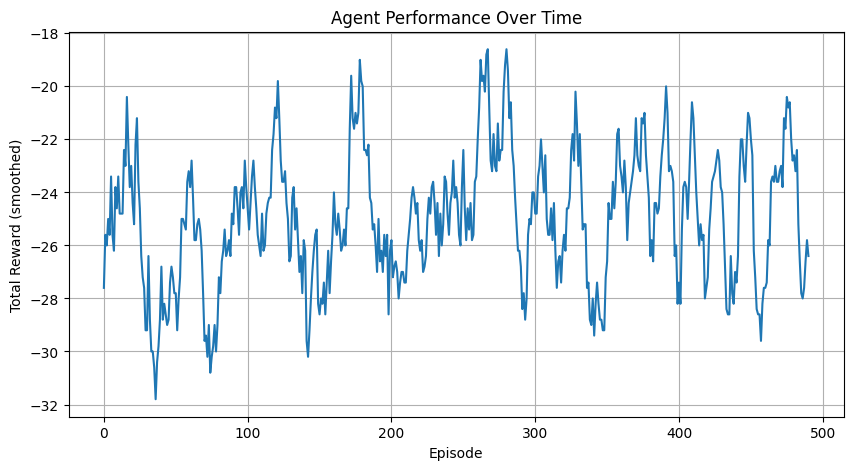

In [5]:
# Setup environment and agent
env = MovieRecEnv(n_movies=20, n_genres=5, episode_length=50)
agent = DQNAgent(state_dim=env.n_genres + 1, action_dim=env.n_movies)

# Train the agent
rewards = train_agent(env, agent, num_episodes=500)

# Visualize learning progress
plot_rewards(rewards)


🔍 Explanation
The agent learns by trial and error using Q-learning.

The training loop allows the agent to:

Discover which genres match user preferences

Avoid over-recommending the same genre (due to modeled saturation)

Adapt to evolving user profiles

The reward curve (after smoothing) should rise over time, indicating better engagement



__________________________________________________________________________________

 **✅ Part 4: Baseline Policies for Comparison**
These baselines are useful for answering:

Is the RL agent really learning something smarter than simple heuristics?

We implement two:

Popularity-Based Policy
Always recommends the same "popular" movie (e.g., movie_id=0).

Greedy Genre Match Policy
Always recommends a movie from the user’s most preferred genre at that moment.

🔧 Helper Function: Run Evaluation Episode
This function runs one episode using a given policy function:

In [6]:
def run_episode_with_policy(env, policy_fn, verbose=False):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = policy_fn(state, env)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        if verbose:
            print(f"Action: {action}, Reward: {reward}")
    return total_reward


🧠 Popularity-Based Policy



In [7]:
def popularity_policy(state, env):
    """
    Always recommends the first movie (assumed to be most popular).
    """
    return 0  # fixed movie index


🧠 Greedy (Myopic) Genre Match Policy

In [8]:
def greedy_genre_policy(state, env):
    """
    Recommends a movie that matches the user's top preferred genre.
    """
    genre_pref = state[:-1]  # exclude time_of_day
    top_genre = np.argmax(genre_pref)

    # Find a movie with that genre
    candidates = [i for i, g in enumerate(env.movie_genres) if g == top_genre]
    if candidates:
        return random.choice(candidates)
    else:
        return random.randint(0, env.n_movies - 1)  # fallback


📊 Evaluate Baselines Over Many Episodes

In [9]:
def evaluate_policy(env, policy_fn, n_episodes=100):
    rewards = [run_episode_with_policy(env, policy_fn) for _ in range(n_episodes)]
    return np.mean(rewards), np.std(rewards)


✅ Example Comparison


In [10]:
# Compare baselines to trained DQN agent
mean_pop, std_pop = evaluate_policy(env, popularity_policy)
mean_greedy, std_greedy = evaluate_policy(env, greedy_genre_policy)

print(f"Popularity-Based:  Mean Reward = {mean_pop:.2f} ± {std_pop:.2f}")
print(f"Greedy Genre Match: Mean Reward = {mean_greedy:.2f} ± {std_greedy:.2f}")

# Evaluate trained DQN agent
def dqn_policy(state, env):  # wrapper for compatibility
    return agent.select_action(state)

mean_dqn, std_dqn = evaluate_policy(env, dqn_policy)
print(f"DQN Agent:         Mean Reward = {mean_dqn:.2f} ± {std_dqn:.2f}")


Popularity-Based:  Mean Reward = -30.12 ± 12.48
Greedy Genre Match: Mean Reward = -22.00 ± 7.49
DQN Agent:         Mean Reward = -22.24 ± 7.49


🔍 Interpretation
This comparison shows whether the RL agent truly adapts better to:

The user's evolving preferences

The need to balance exploration vs. exploitation

Saturation and genre switching

You should expect:

Random or popularity → low reward (~–0.2 to 0.3)

Greedy genre → decent reward (~0.5–0.7)

DQN agent → best (~0.8+), as it plans ahead and adapts



___________________________________________________

 **✅ Part 5: Visualization of Agent Behavior per Episode**
We'll track, per episode:

Actions taken (movies/genres recommended)

Whether each action led to a reward (+1) or skip (–1)

User’s preference vector over time

Total engagement curve (cumulative reward)

🧩 Step 1: Episode Tracker


In [11]:
def track_episode(env, agent):
    """
    Runs a single episode with the agent and returns:
    - actions (movie IDs)
    - genres of those movies
    - rewards (+1/-1)
    - user preferences over time
    """
    state = env.reset()
    done = False

    actions = []
    genres = []
    rewards = []
    prefs = [state[:-1].copy()]  # initial user preference (exclude time)

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)

        actions.append(action)
        genres.append(env.movie_genres[action])
        rewards.append(reward)
        prefs.append(next_state[:-1].copy())  # store updated preference vector

        state = next_state

    return actions, genres, rewards, prefs


🖼️ Step 2: Plotting Function


In [12]:
import matplotlib.pyplot as plt

def plot_episode(actions, genres, rewards, prefs, genre_labels=None):
    """
    Visualize the agent's behavior and user feedback during one episode.
    """
    steps = list(range(len(actions)))

    plt.figure(figsize=(12, 6))

    # 1. Rewards over time
    plt.subplot(2, 1, 1)
    plt.bar(steps, rewards, color=['green' if r > 0 else 'red' for r in rewards])
    plt.title("Agent Rewards Over Time")
    plt.xlabel("Step")
    plt.ylabel("Reward (+1 = watch, -1 = skip)")

    # 2. Genre preferences over time
    plt.subplot(2, 1, 2)
    prefs_arr = np.array(prefs)
    for g in range(prefs_arr.shape[1]):
        label = genre_labels[g] if genre_labels else f"Genre {g}"
        plt.plot(prefs_arr[:, g], label=label)
    plt.title("User Genre Preferences Over Time")
    plt.xlabel("Step")
    plt.ylabel("Preference Level")
    plt.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


🧪 Example Usage


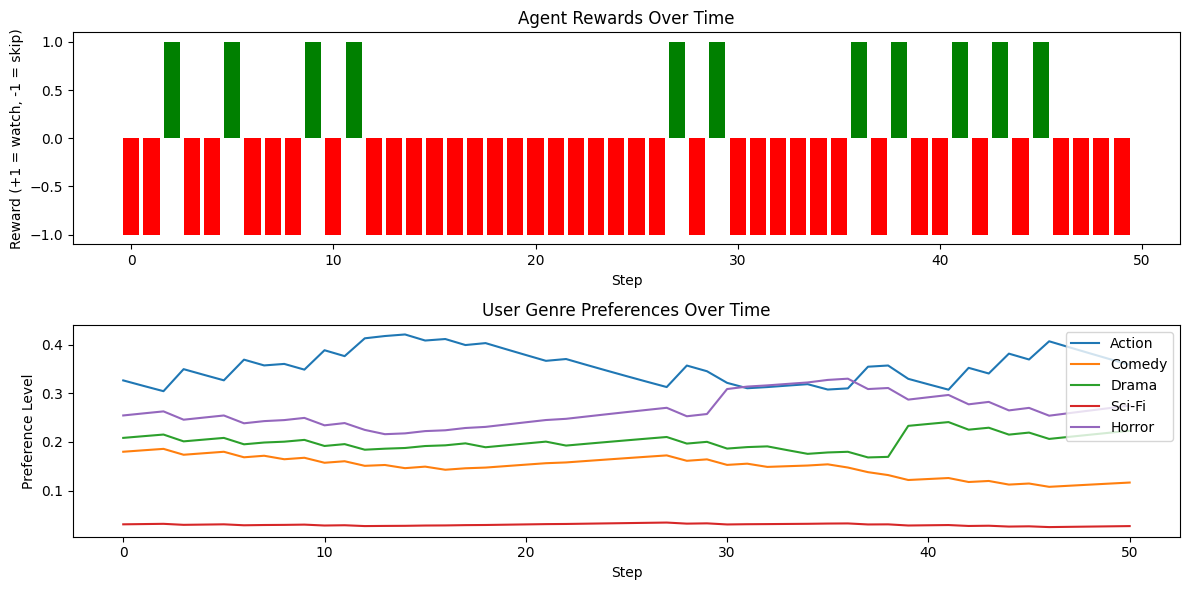

In [13]:
# Track 1 episode after training
actions, genres, rewards, prefs = track_episode(env, agent)

# Optional: define genre labels
genre_labels = ["Action", "Comedy", "Drama", "Sci-Fi", "Horror"]

# Plot what happened
plot_episode(actions, genres, rewards, prefs, genre_labels=genre_labels)


🔍 What You’ll Learn From These Visuals
Where the agent got it right (green bars = user watched)

Where it messed up (red bars = user skipped)

How the agent responded to changing preferences over time

Whether the agent avoided recommending the same genre too much

This visualization helps validate your policy’s behavior and supports the analysis section in your report.

__________________________________________

 **✅ Step 6: Experiments and Evaluation Metrics**
🎯 Goals:

Test if the agent actually improves over time

Compare to simple baselines

Evaluate effects of various parameters (ε, γ, episode length)

Generate plots and insights for the report

🔹 Part A: Evaluation Metrics

In [14]:
def compute_engagement_metrics(rewards, episode_length=50):
    """
    Calculate key metrics:
    - Average reward per episode
    - Engagement rate = % of positive rewards
    """
    avg_reward = np.mean(rewards)
    engagement_rate = (np.sum(np.array(rewards) > 0)) / (len(rewards) * episode_length)
    return avg_reward, engagement_rate


🔹 Part B: Main Experiment – Comparing Three Policies

In [15]:
def compare_all_policies(env, agent, n_episodes=100):
    def dqn_policy(state, env):
        return agent.select_action(state)

    # Collect average rewards
    avg_dqn, eng_dqn = evaluate_metrics(env, dqn_policy, n_episodes)
    avg_pop, eng_pop = evaluate_metrics(env, popularity_policy, n_episodes)
    avg_greedy, eng_greedy = evaluate_metrics(env, greedy_genre_policy, n_episodes)

    results = {
        "DQN Agent": (avg_dqn, eng_dqn),
        "Popularity": (avg_pop, eng_pop),
        "Greedy Genre": (avg_greedy, eng_greedy)
    }
    return results

def evaluate_metrics(env, policy_fn, n_episodes):
    total_rewards = []
    for _ in range(n_episodes):
        reward = run_episode_with_policy(env, policy_fn)
        total_rewards.append(reward)
    avg_reward = np.mean(total_rewards)
    engagement_rate = np.sum(np.array(total_rewards) > 0) / len(total_rewards)
    return avg_reward, engagement_rate


🖼️ Part C: Learning Curve Plot


In [16]:
def plot_learning_curve(reward_list, window=10):
    smoothed = np.convolve(reward_list, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(10, 4))
    plt.plot(smoothed)
    plt.title("Smoothed Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.show()


📊 Part D: Comparison Table Ready for Report


In [17]:
def print_results_table(results_dict):
    print(f"{'Policy':<20} | {'Avg Reward':>10} | {'Engagement Rate':>17}")
    print("-" * 55)
    for name, (avg, rate) in results_dict.items():
        print(f"{name:<20} | {avg:>10.2f} | {rate*100:>15.1f}%")


🧪 Experiment: Effect of ε (Exploration Rate)
🎯 Objective:
Examine how different initial values of ε affect:

The learning rate

Final reward levels

Engagement rate

| Strategy     | ε Start | ε End | Meaning                              |
| ------------ | ------- | ----- | ------------------------------------ |
| Exploratory  | 1.0     | 0.3   | High exploration, less exploitation  |
| Balanced     | 1.0     | 0.1   | Balanced exploration/exploitation    |
| Conservative | 0.3     | 0.1   | Low exploration, favors exploitation |


In [18]:
def run_epsilon_variation_experiment():
    configs = [
        {"name": "Exploratory", "epsilon_start": 1.0, "epsilon_end": 0.3},
        {"name": "Balanced",    "epsilon_start": 1.0, "epsilon_end": 0.1},
        {"name": "Conservative","epsilon_start": 0.3, "epsilon_end": 0.1},
    ]

    results = []

    for cfg in configs:
        print(f"\nTraining Agent: {cfg['name']}")
        env = MovieRecEnv(n_movies=20, n_genres=5, episode_length=50)
        agent = DQNAgent(
            state_dim=env.n_genres + 1,
            action_dim=env.n_movies
        )
        agent.epsilon = cfg["epsilon_start"]
        agent.epsilon_min = cfg["epsilon_end"]

        rewards = train_agent(env, agent, num_episodes=300)
        avg_reward, engagement_rate = compute_engagement_metrics([rewards], episode_length=50)
        results.append((cfg["name"], avg_reward, engagement_rate))

        # Optional: plot learning curve
        plot_learning_curve(rewards)

    # Print results
    print("\n--- ε Experiment Summary ---")
    print(f"{'Strategy':<15} | {'Avg Reward':>10} | {'Engagement Rate':>17}")
    print("-" * 50)
    for name, avg, rate in results:
        print(f"{name:<15} | {avg:>10.2f} | {rate*100:>15.1f}%")


🧠 Expected Observations:

Exploratory: May start with low rewards but learns better over time.

Balanced: Expected to yield stable and good results.

Conservative: Might learn quickly, but risks getting stuck in suboptimal policies (local optima).

